# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Bernat Quintilla Castellón</font>

E-mail: <font color="blue">bernat.quintilla01@estudiant.upf.edu</font>

Date: <font color="blue">20/10/2023</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [2]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [3]:
def jaccard_similarity(l1, l2):
    set1 = set(l1)
    set2 = set(l2)

    size_intersec = len(set1.intersection(set2))
    size_union = len(set1.union(set2))

    if size_union == 0:
        return 0.0  #creo el condicional per evitar divisió amb denominador=0
    else:
        return size_intersec/size_union

In [4]:
#1. similarity 0.6666...
case11 = [1, 2, 3, 4, 5]
case12 = [1, 2, 3, 4, 6]
case1_res = jaccard_similarity(case11, case12)
print("1st case Jaccard Similarity: ",case1_res)

#2. similarity 0.75
case21 = [1, 2, 3, 4]
case22 = [1, 2, 3]
case2_res = jaccard_similarity(case21, case22)
print("2nd case Jaccard Similarity: ",case2_res)

#3. similarity 1.0
case31 = [1, 2, 3]
case32 = [1, 2, 3]
case3_res = jaccard_similarity(case31, case32)
print("3rd case Jaccard Similarity: ",case3_res)

#4. similarity 0.0
case41 = []
case42 = []
case4_res = jaccard_similarity(case41, case42)
print("4th case Jaccard Similarity: ",case4_res)

1st case Jaccard Similarity:  0.6666666666666666
2nd case Jaccard Similarity:  0.75
3rd case Jaccard Similarity:  1.0
4th case Jaccard Similarity:  0.0


In [5]:
def clean(text):
    text = re.sub("RT ", "",text) #Removing "RT " prefixes

    text = text.lower() #Converting to lowercase

    text = re.sub('ñ', 'n',text) #Romanizing text (tenint en compte que els idiomes a romanitzar són català, castellà o anglès)
    text = re.sub('à', 'a',text)
    text = re.sub('á', 'a',text)
    text = re.sub('è', 'e',text)
    text = re.sub('é', 'e',text)
    text = re.sub('í', 'i',text)
    text = re.sub('ó', 'o',text)
    text = re.sub('ò', 'o',text)
    text = re.sub('ú', 'u',text)
    text = re.sub('ü', 'u',text)
    text = re.sub('l·l','ll',text)
    
    text = re.sub(r'http\S+', '', text) #Removing URLs, both "http" and "https" ones
    text = re.sub(r'https\S+', '', text) #Removes "http" and "https" followed by \S+ (a string of non-whitespace characters)

    text = text.strip() #Removing spaces at the beginning and spaces at the end with the strip() function.
    
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text) #Removing anything that remains that is not a letter or digit
    
    text = re.sub(r"\s+"," ", text) #Changing multiple spaces to single spaces, using \s+ (a string of whitespace characters)
    
    return text

In [6]:
test_texts = ["RT Hello World!"#RT Test
             ,"Sal·ly plàÑñed àn ànnuàl celebràtión"#Romanizing Test
             ,"I like this websites: http://url1, https://url2"#URL Test
             ,"This !@#$text does not have special (symbols¿¡?"#Special Symbols Test
             ," Remove  spaces  test "]#Removing spaces at the beginning and end, and double spaces Test
for test_text in test_texts:
    clean_text = clean(test_text)
    print(clean_text,"\n")

hello world  

sally planned an annual celebration 

i like this websites  

this text does not have special symbols  

remove spaces test 



# 2. Implement an n-gram extractor

In [7]:
MIN_TOKEN_LENGTH = 3
def ngrams(text, size):
    tokens = clean(text).split() #Separem paraules text una vegada clean i guardem a tokens
    filt_tokens = [] #Creem llista auxiliar per guardar els tokens els quals len(token)>=MIN_TOKEN_LENGTH
    for token in tokens:
        if len(token) >= MIN_TOKEN_LENGTH:
            filt_tokens.append(token)
    ngrams = [] #Llista de ngrams guardem combinacions de tamany size
    for i in range(len(filt_tokens) - size+1):
        ngrams.append(' '.join(filt_tokens[i:i+size]))
        
    return ngrams

In [8]:
#Function Test
print(messages[9780])
print(ngrams(messages[9780], 3))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants xinesos', 'comerciants xinesos donen', 'xinesos donen mascaretes', 'donen mascaretes gel', 'mascaretes gel antiseptic', 'gel antiseptic badalona', 'antiseptic badalona per', 'badalona per lluitar', 'per lluitar contra', 'lluitar contra coronavirus']


# 3. Estimation for brute force method

In [9]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

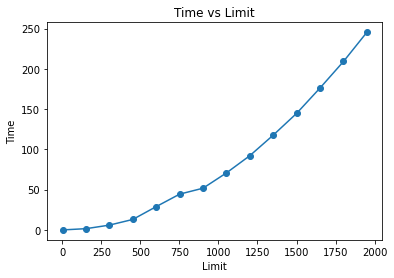

In [10]:
limits = list(range(1, 2001, 150)) #set x from 1 to 2001 in increments of 150
list_time = [] #for each limit use time_brute_force_similarities and save the time it takes in list_time

for limit in limits:
    time_takes = time_brute_force_similarities(messages, limit, 4)
    list_time.append(time_takes)

plt.plot(limits, list_time, marker='o') #generate the plot (use of marker='o' to see the points clearly as painted circles)
plt.title('Time vs Limit')
plt.xlabel('Limit')
plt.ylabel('Time')
plt.show()

```(1)``` This plot shows how the increase of the limit, increases exponentially the time that it takes the use of the function time_brute_force_similarities. 


```(2)``` For the entire input matrix the limit we should pass to the function is 10000. As said before seing the plot we can guess that it is followed a quadratic function, so: y = ax<sup>2</sup> + bx + c. If we get 2 different points from the plot we can compute the approximate values of a,b and c, and then substitute the value of x. I have done the calculation in the following cell, and the estimated time for how long it would take to run the brute force similarity computations for the entire input matrix is 1968.199s (0.547h).

In [27]:
def find_quadratic_parameters(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    a = (y1*x2 - y2*x1)/((x1^2)*x2-(x2^2)*x1) #algebraic calculations made on paper
    b = (y1 - a*(x1^2))/x1
    c=0 #for our case we can assume that c=0
    return a, b, c

def expected_value(point1,point2,x):
    a, b, c = find_quadratic_parameters(point1,point2)
    y = a*(x^2) + b*x + c #we apply the quadratic function form
    return y

time_takes_input_mat = expected_value((limits[10],list_time[10]), (limits[12], list_time[12]),10000) #we take advanced points because the slope will be more like the expected

print(round(time_takes_input_mat,3),"s  -->  ",round(time_takes_input_mat/3600,3),"h")

1968.199 s  -->   0.547 h


# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [12]:
NGRAM_SIZE = 3 #Modifico NGRAM_SIZE i MIN_TOKEN_LENGTH per dur a terme els tests de la pròxima cela
MIN_TOKEN_LENGTH=2

ngram_to_index = {}
index_to_ngram = {}
next_index = 0 #creem contador que usarem con index

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE) #Guardem tots els ngrams de message
    for ngram in all_ngrams:
        if ngram not in ngram_to_index: 
            ngram_to_index[ngram] = next_index #si no és a dict l'afegim amb l'index pertinent
            index_to_ngram[next_index] = ngram #inversament de la mateixa forma per index_to_ngram
            next_index += 1
num_distinct_ngrams = next_index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 68836 distinct ngrams in the 10000 documents


In [13]:
test_string1 = "tancat escoles fins"
test_string2 = "garantir la seguretat"

index1 = ngram_to_index[test_string1] #obtenim index per mitjà de string amb ngram_to_index
index2 = ngram_to_index[test_string2]

print(f"ngram_to_index for '{test_string1}': {index1}") 
print(f"ngram_to_index for '{test_string2}': {index2}")

ngram1 = index_to_ngram[index1] #obtenim la mateixa string (ja que és un ngram), a partir del index
ngram2 = index_to_ngram[index2]

print(f"index_to_ngram for '{index1}': {ngram1}")
print(f"index_to_ngram for '{index2}': {ngram2}")

ngram_to_index for 'tancat escoles fins': 977
ngram_to_index for 'garantir la seguretat': 34
index_to_ngram for '977': tancat escoles fins
index_to_ngram for '34': garantir la seguretat


## 2.2 Create table ngrams x documents

In [14]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 68836 rows (distinct shingles) x 10000 columns (distinct documents)


In [15]:
for docid in range(len(messages)):
    message = messages[docid]
    ngrams_message = ngrams(message, NGRAM_SIZE)
    for ngram in ngrams_message:
        ngram_index = ngram_to_index[ngram] #obtenim index a partir de ngram
        M_ngram_doc[ngram_index, docid] = True #set that position to True because document j contains ngram i

In [16]:
num_non_zeroes_mat = np.count_nonzero(M_ngram_doc) #This np function returns the count of non-zero elements in the array.
num_cells_mat = M_ngram_doc.size #size returns the number of cells of the matrix in this case
density_mat = round((num_non_zeroes_mat / num_cells_mat) * 100,4) #density of the matrix computation

print("Matrix density: ",density_mat,"%")

Matrix density:  0.0236 %


In [17]:
#9602
docid1 = 9602
print("\033[4mPositions of non-zeros in column of docid ",docid1," of M_ngram_doc\033[0m\n") #How to underline searched in the internet
print("Clean message for docid", docid1,":")
print(clean(messages[docid1])) #Show message cleaned
print("\nNon-zeros in row ",docid1,":")
non_zero_docid1_row = np.nonzero(M_ngram_doc[:, docid1])[0] #for column docid1 we extract the indices of the nonzero values as an array
print(non_zero_docid1_row)                                  #np.nonzero returns a tuple and we select the first and only array using [0]
print([f"{pos} ({index_to_ngram[pos]})" for pos in non_zero_docid1_row]) #print as in the example iterating in each position

#941
docid2 = 941 #same process with document id 941
print("\n\033[4mPositions of non-zeros in column of docid ",docid2," of M_ngram_doc\033[0m\n")
print("Clean message for docid", docid2,":")
print(clean(messages[docid2]))
print("\nNon-zeros in row ",docid2,":")
non_zero_docid2_row = np.nonzero(M_ngram_doc[:, docid2])[0]
print([f"{pos} ({index_to_ngram[pos]})" for pos in non_zero_docid2_row])

Positions of non-zeros in column of docid  9602  of M_ngram_doc

Clean message for docid 9602 :
 emergenciescat que puc fer i que no faqs del coronavirus a 14 de mar si us plau demanem difusio 

Non-zeros in row  9602 :
[  948  1267  1268  1269  1270  2658 40222 40223 40224 40225 40226 40227
 40228 40229 40230]
['948 (si us plau)', '1267 (emergenciescat que puc)', '1268 (que puc fer)', '1269 (puc fer que)', '1270 (fer que no)', '2658 (14 de mar)', '40222 (que no faqs)', '40223 (no faqs del)', '40224 (faqs del coronavirus)', '40225 (del coronavirus 14)', '40226 (coronavirus 14 de)', '40227 (de mar si)', '40228 (mar si us)', '40229 (us plau demanem)', '40230 (plau demanem difusio)']

Positions of non-zeros in column of docid  941  of M_ngram_doc

Clean message for docid 941 :
 hospiolot usem de forma responsable els recursos sanitaris 061 urgencies per coronavirus i sanitaries 012 consultes general 

Non-zeros in row  941 :
['1530 (usem de forma)', '1531 (de forma responsable)', '1532 (f

# 3. Implement a permutation generator

In [18]:
def random_permutation(k):
    list_to_shuffle = list(range(k)) #Creem llista amb valors del 0 a k-1
    random.shuffle(list_to_shuffle) #Barregem els valors de la llista usant shuffle
    return list_to_shuffle

In [19]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['2 (test2)', '1 (test1)', '3 (test3)', '5 (test5)', '4 (test4)']
['2 (gamma)', '1 (alpha)', '3 (beta)', '5 (epsilon)', '4 (delta)']

Test another permutation
['5 (test5)', '4 (test4)', '3 (test3)', '1 (test1)', '2 (test2)']
['5 (epsilon)', '4 (delta)', '3 (beta)', '1 (alpha)', '2 (gamma)']


# 4. Compute the signature of each document

In [20]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 63410, 46075, 3013, ...
Permutation 1: 31224, 50103, 20241, ...
Permutation 2: 16356, 31456, 6118, ...
Permutation 3: 21002, 17462, 7131, ...
Permutation 4: 59033, 22802, 38904, ...


In [21]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        
        first_ngram = find_first_one(docid, permutation) #Usem la funció donada passant per paràmetre docid i la permutació
        
        M_signature_doc[permutation_num, docid] = first_ngram #Guardem el primer ngram a matriu a la posició [permutation_num, docid]

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [22]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message :  gencat el govern de la gencat anuncia el confinament de tot catalunya davant l emergencia de la covid19 el missatge es clau 
Ngrams        : [62, 3437, 3564, 4227, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057]
Signature     : [5045.0, 5055.0, 5057.0, 5047.0, 62.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicat coronavirus el govern de la gencat anuncia el confinament de tot catalunya davant l emergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la p

# 5. Compare all pairs of signatures

In [25]:
is_possible_duplicate = {}

MATCH_THRESHOLD = 50
PARTIAL_THRESHOLD = 0.2

# Iterate through all documents
for docid1 in range(len(messages)):

    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))
        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # Compare the signatures
                full_match = all(s1 == s2 for s1, s2 in zip(signature1, signature2))
                partial_match = sum(s1 == s2 for s1, s2 in zip(signature1, signature2)) / NUM_PERMUTATIONS
                # Check for full matches
                if full_match:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = docid1
                # Check for partial matches
                elif partial_match > PARTIAL_THRESHOLD:
                    count_sig_partial_matches += 1

        # If the number of partial matches plus full matches exceeds a threshold
        if count_sig_full_matches + count_sig_partial_matches > MATCH_THRESHOLD:
            print("Document #%d has %d full signature matches and %d partial signature matches" % (docid1, count_sig_full_matches, count_sig_partial_matches))

0/10000 documents scanned
Document #16 has 71 full signature matches and 2 partial signature matches
Document #20 has 28 full signature matches and 25 partial signature matches
Document #53 has 57 full signature matches and 0 partial signature matches
Document #73 has 17 full signature matches and 34 partial signature matches
Document #166 has 56 full signature matches and 0 partial signature matches
Document #328 has 65 full signature matches and 0 partial signature matches
500/10000 documents scanned
1000/10000 documents scanned
2000/10000 documents scanned
3500/10000 documents scanned
4000/10000 documents scanned
4500/10000 documents scanned
5000/10000 documents scanned
Document #5077 has 176 full signature matches and 3 partial signature matches
Document #5109 has 66 full signature matches and 0 partial signature matches
Document #5117 has 71 full signature matches and 0 partial signature matches
Document #5129 has 54 full signature matches and 0 partial signature matches
Document 

In [30]:
#Showing the tweet (document #5077) because has 176 complete matches but only 3 partial matches
print(messages[5077])

RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK


In the case of this specific tweet, it contains factual information of a static resource (FAQs) related to the coronavirus and because of that it is likely not changing much when copied or retweeted. People generally share this kind of information as-is because it is intended to provide accurate and up-to-date guidance. Because of that the tweet has a substancial number of complete matches but few partial matches

In [32]:
#Showing the tweet (document #73) because has 34 partial matches but only 17 complete matches
print(messages[73])

RT @VilaWeb: [VÍDEO] Ortega Smith passejant per Madrid sense mascareta i amb la seva mare després del positiu de coronavirus https://t.co/M…


In this case, the tweet does not give crucial information like in the previous case, and because of that people tend to change the words of the tweet and add information. The message of this tweet leads to retweets giving different opinions adding information. For example one retweet could be like the following one:

Vídeo impactant d'Ortega Smith passejant sense mascareta per Madrid després del positiu de coronavirus. Això és tan irresponsable! 😷 #COVID19 #OrtegaSmith #Madrid

In this example we can clearly see how the new tweet is different from the first one, using different words, giving opinions and adding hashtags. This leads to a substancial number of partial matches but fewer complete matches.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>